In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import INT_TO_CHAR, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_dataset, get_aa_properties
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve

from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

RESDIR='../output/train_eval/'

In [12]:
from src.data_processing import encode_batch
seq = 'FLLEVLAMV'


['F', 'L', 'L', 'E', 'V', 'L', 'A', 'M', 'V']

[Text(0, 0.5, 'A'),
 Text(0, 1.5, 'R'),
 Text(0, 2.5, 'N'),
 Text(0, 3.5, 'D'),
 Text(0, 4.5, 'C'),
 Text(0, 5.5, 'Q'),
 Text(0, 6.5, 'E'),
 Text(0, 7.5, 'G'),
 Text(0, 8.5, 'H'),
 Text(0, 9.5, 'I'),
 Text(0, 10.5, 'L'),
 Text(0, 11.5, 'K'),
 Text(0, 12.5, 'M'),
 Text(0, 13.5, 'F'),
 Text(0, 14.5, 'P'),
 Text(0, 15.5, 'S'),
 Text(0, 16.5, 'T'),
 Text(0, 17.5, 'W'),
 Text(0, 18.5, 'Y'),
 Text(0, 19.5, 'V')]

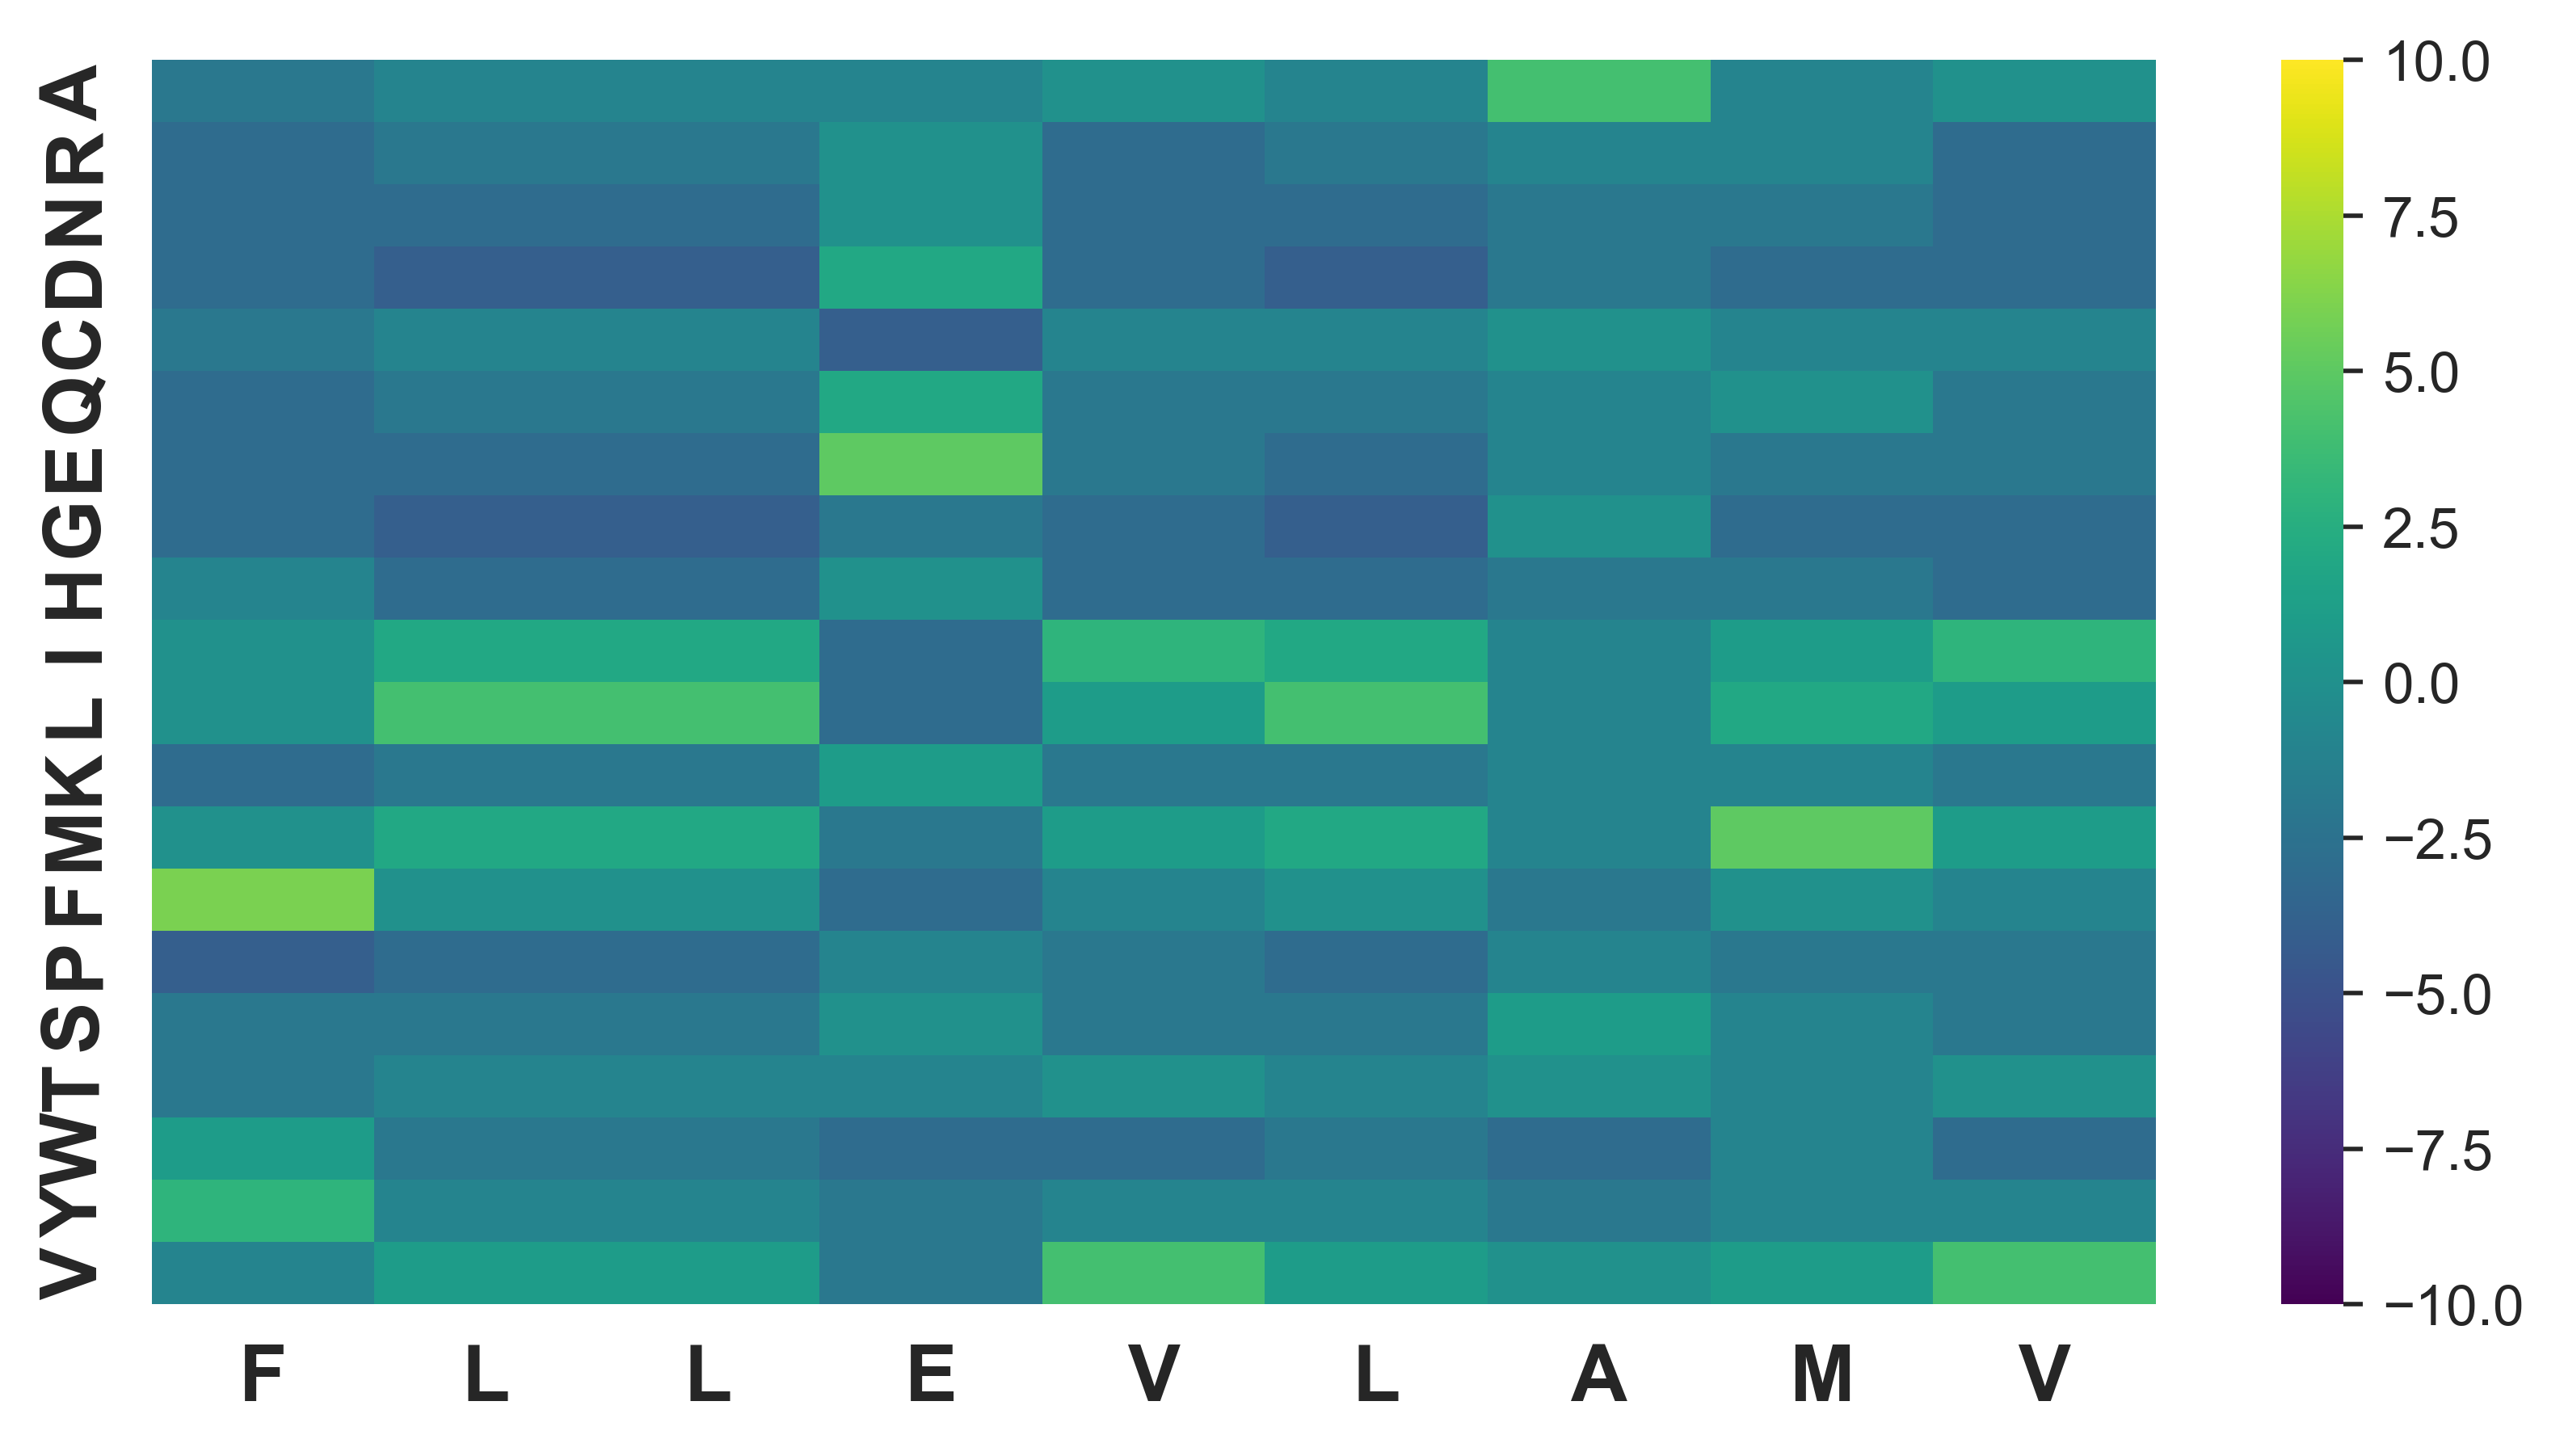

In [42]:
from src.data_processing import AA_KEYS
xx = encode_batch([seq], max_len=9, encoding='blosum', blosum_matrix=BL62_VALUES)
sns.set_palette('viridis')
mpl.rcParams['figure.dpi'] = 500
f,a = plt.subplots(1,1, figsize=(8,4))
sns.heatmap(pd.DataFrame(xx.view(9,20), index=[x for x in seq], columns=AA_KEYS).T, center=0, 
            vmin=-10, vmax=10, cmap='viridis', ax=a)
a.set_xticklabels(a.get_xticklabels(), fontsize=14, fontweight='semibold')
a.set_yticklabels(a.get_yticklabels(), fontsize=14, fontweight='semibold')

In [50]:
xx_pad

tensor([[[-2., -3., -3., -3., -2., -3., -3., -3., -1.,  0.,  0., -3.,  0.,  6.,
          -4., -2., -2.,  1.,  3., -1.],
         [-1., -2., -3., -4., -1., -2., -3., -4., -3.,  2.,  4., -2.,  2.,  0.,
          -3., -2., -1., -2., -1.,  1.],
         [-1., -2., -3., -4., -1., -2., -3., -4., -3.,  2.,  4., -2.,  2.,  0.,
          -3., -2., -1., -2., -1.,  1.],
         [-1.,  0.,  0.,  2., -4.,  2.,  5., -2.,  0., -3., -3.,  1., -2., -3.,
          -1.,  0., -1., -3., -2., -2.],
         [ 0., -3., -3., -3., -1., -2., -2., -3., -3.,  3.,  1., -2.,  1., -1.,
          -2., -2.,  0., -3., -1.,  4.],
         [-1., -2., -3., -4., -1., -2., -3., -4., -3.,  2.,  4., -2.,  2.,  0.,
          -3., -2., -1., -2., -1.,  1.],
         [ 4., -1., -2., -2.,  0., -1., -1.,  0., -2., -1., -1., -1., -1., -2.,
          -1.,  1.,  0., -3., -2.,  0.],
         [-1., -1., -2., -3., -1.,  0., -2., -3., -2.,  1.,  2., -1.,  5.,  0.,
          -2., -1., -1., -1., -1.,  1.],
         [ 0., -3., -3., -3., -1

[Text(0, 0.5, 'F'),
 Text(0, 1.5, 'L'),
 Text(0, 2.5, 'L'),
 Text(0, 3.5, 'E'),
 Text(0, 4.5, 'V'),
 Text(0, 5.5, 'L'),
 Text(0, 6.5, 'A'),
 Text(0, 7.5, 'M'),
 Text(0, 8.5, 'V'),
 Text(0, 9.5, 'Pad'),
 Text(0, 10.5, 'Pad')]

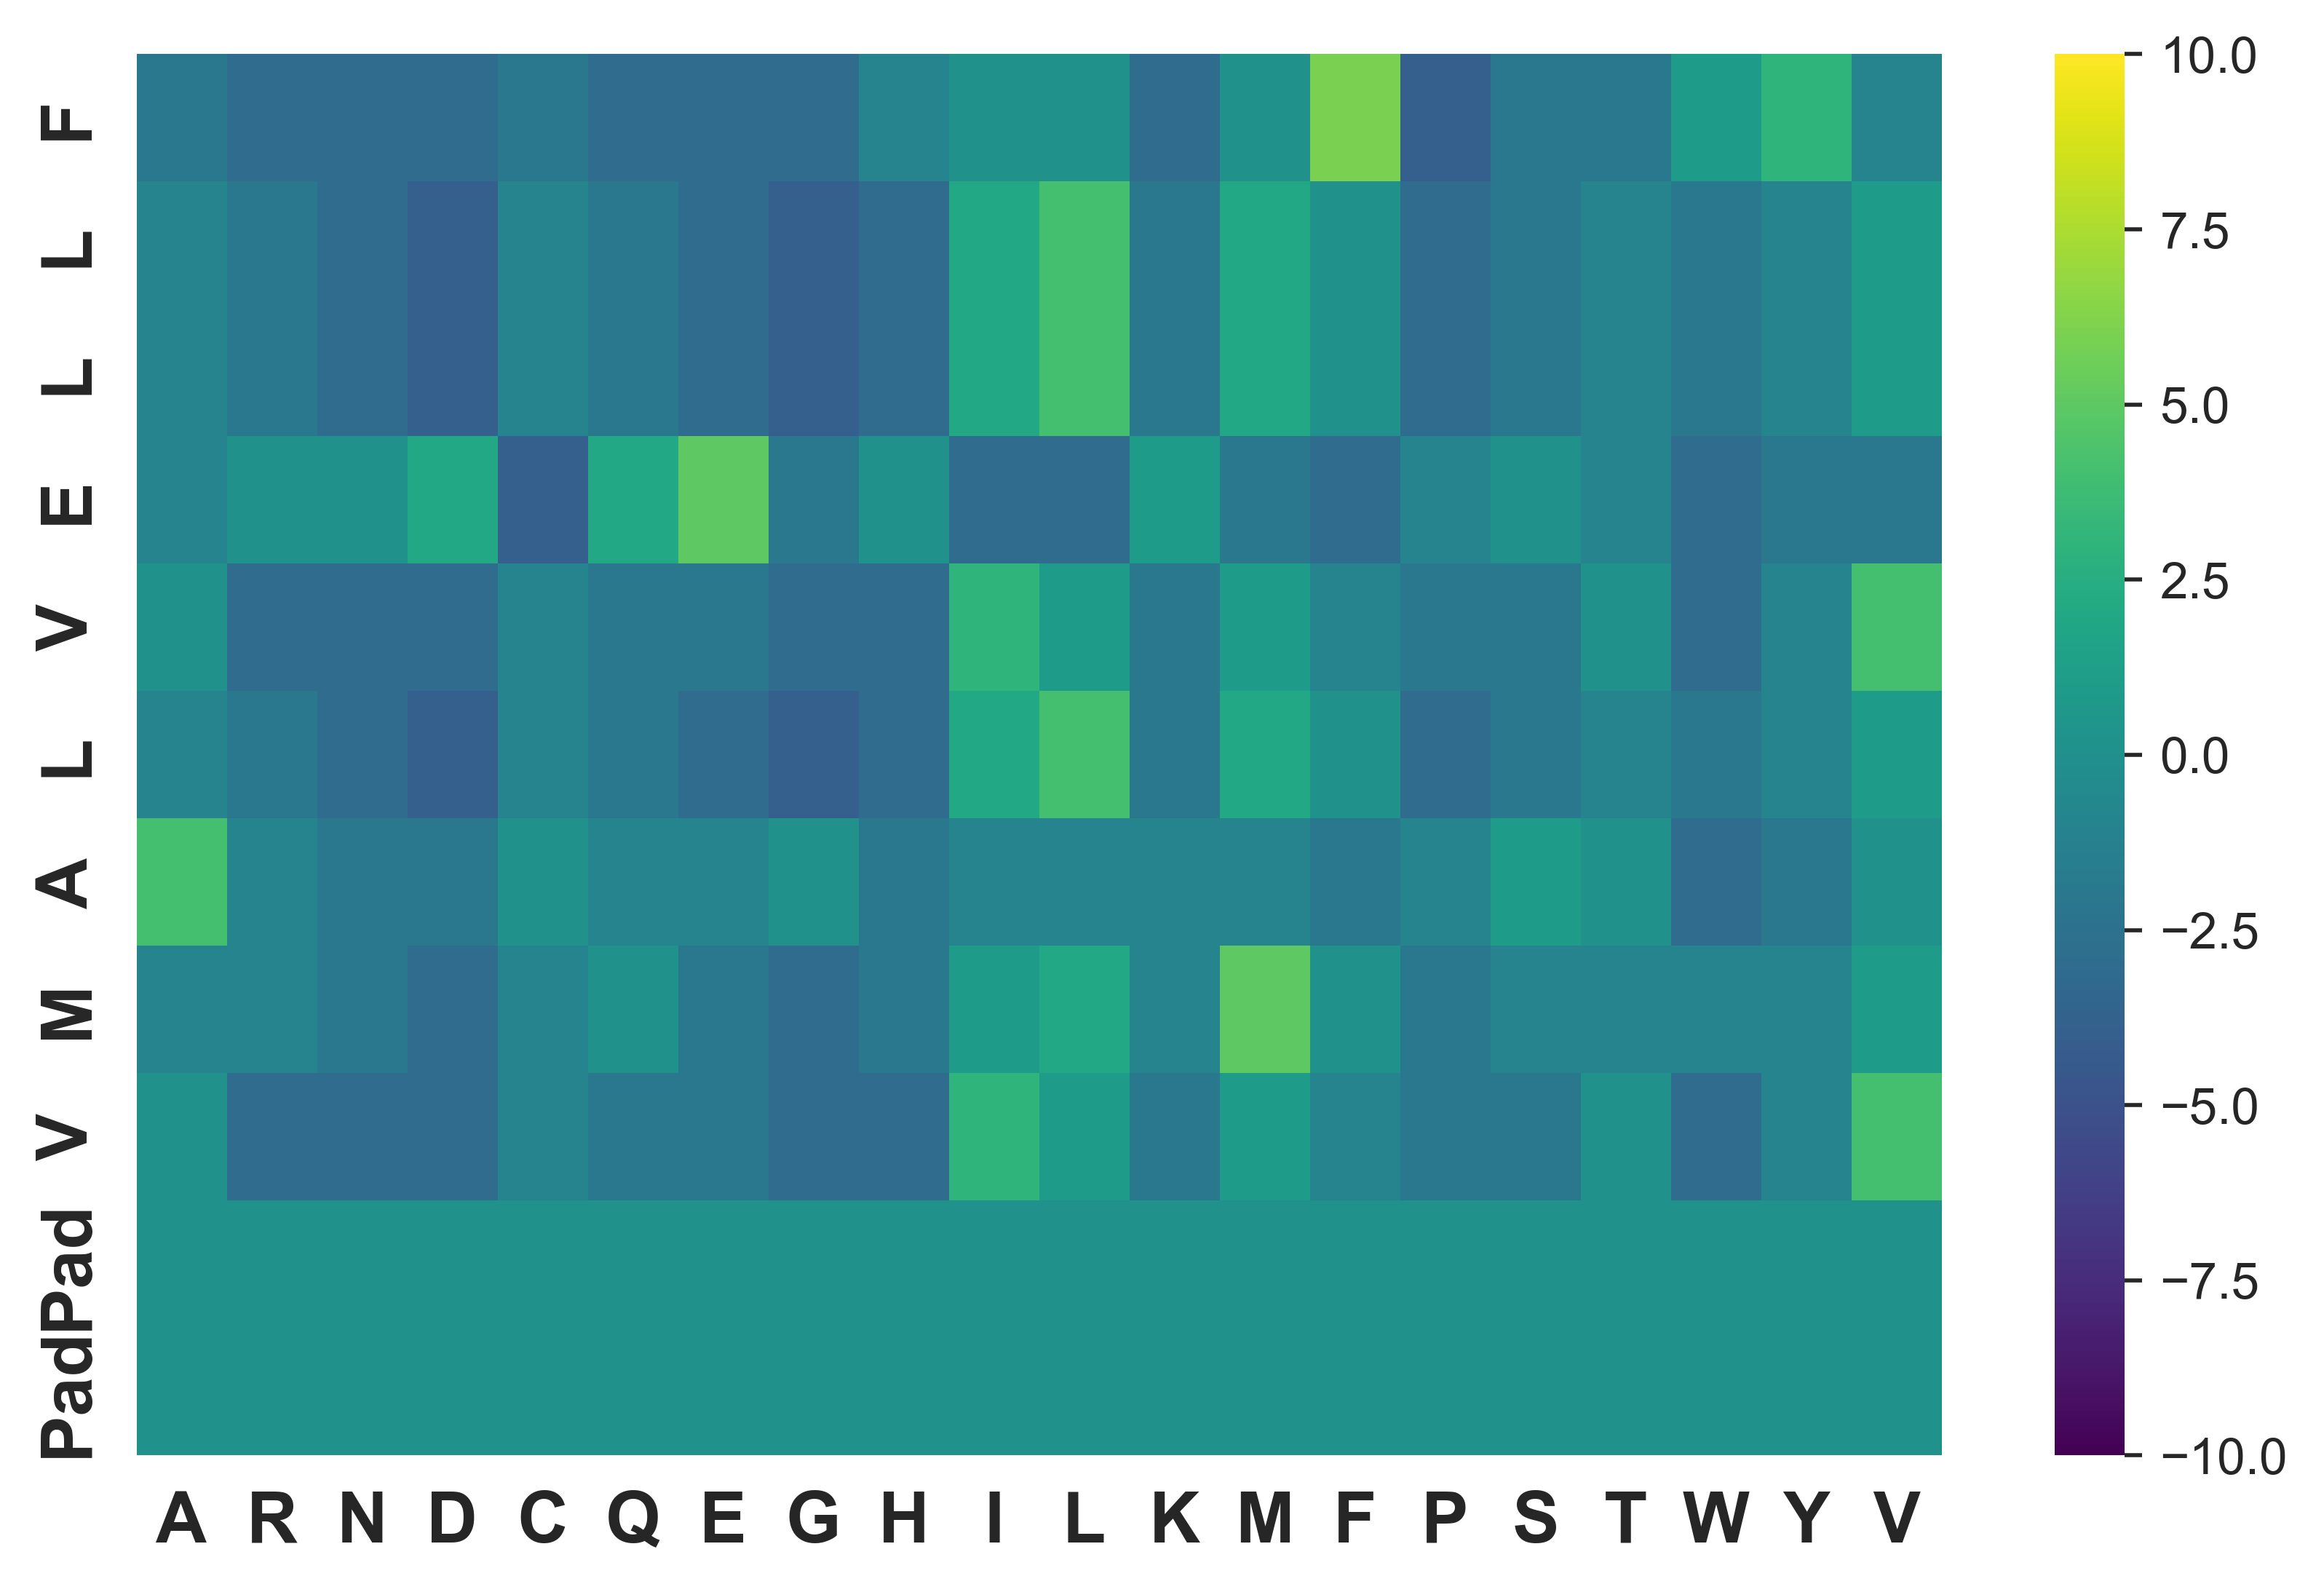

In [49]:
from src.data_processing import AA_KEYS
xx_pad = encode_batch([seq], max_len=11, encoding='blosum', blosum_matrix=BL62_VALUES)
sns.set_palette('viridis')
mpl.rcParams['figure.dpi'] = 500
f,a = plt.subplots(1,1, figsize=(8,5))
sns.heatmap(pd.DataFrame(xx_pad.view(-1,20), index=[x for x in seq]+['Pad','Pad'], columns=AA_KEYS), center=0, 
            vmin=-10, vmax=10, cmap='viridis', ax=a)
a.set_xticklabels(a.get_xticklabels(), fontsize=14, fontweight='semibold')
a.set_yticklabels(a.get_yticklabels(), fontsize=14, fontweight='semibold')

In [2]:
mapping={
    'aliphatic_index': 'Aliphatic Index', 
    'boman': 'Boman index', 
    'charge_7_4': 'Charge at pH=7.4', 
    'charge_6_65': 'Charge at pH=6.65', 
    'hydrophobicity': 'Hydrophobicity', 
    'isoelectric_point': 'Isoelectric Point', 
    'PD2': 'PD2', 
    'VHSE1': 'VHSE1', 
    'VHSE2': 'VHSE2', 
    'VHSE3': 'VHSE3', 
    'VHSE4': 'VHSE4', 
    'VHSE5': 'VHSE5', 
    'VHSE6': 'VHSE6', 
    'VHSE7': 'VHSE7', 
    'VHSE8': 'VHSE8'}

In [3]:
# Checking distributions 
from scipy.stats import mannwhitneyu, ttest_ind

def plot_aaprops(vals, index, label_column='agg_label', rank_column='trueHLA_EL_rank', title = 'Different AA properties on CEDAR\nONE-SIDED MW-U and Welch tests'):
    pal = sns.color_palette('hsv', n_colors = 13)
    sns.set_palette([pal[-4], pal[-1]])
    f,a = plt.subplots(8,2, figsize = (10, 32))
    ax = a.ravel()
    
    hue = [label_column]
    for i,key in enumerate([rank_column]+index):#
        #, 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65', 'hydrophobicity', 
         #                   'isoelectric_point', 'PD2',  'VHSE1', 'VHSE2', 'VHSE3', 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']):
        gb=vals.groupby(label_column)[key].agg(['mean', 'median'])
        med_0 = gb.loc[0,'median']
        med_1 = gb.loc[1, 'median']
        sns.histplot(data = vals, x = key, hue=label_column, alpha = 0.4, 
                     kde=True, ax=ax[i], legend=True, hue_order=[0,1])
        # Reset max ylim
        upper = ax[i].get_ylim()[1]
        ax[i].set_ylim([0, upper* 1.15])
        xlabel = mapping[key] if i!=0 else 'NetMHCpan %EL Rank'
        ax[i].set_xlabel(xlabel, fontweight='semibold')
        # Mann Whitney U test
        pos, neg = vals.query(f'{label_column}==1')[key].values, vals.query(f'{label_column}==0')[key].values
        
        alt_t = 'greater' if pos.mean()>neg.mean() else 'less'
        """
        ‘less’: the distribution underlying x is stochastically less than the distribution underlying y, i.e. F(u) > G(u) for all u.
        """
        alt_mw = 'less' if pos.mean() < neg.mean() else 'greater'
        
        _, pval_mw = mannwhitneyu(pos, neg, alternative=alt_mw)
        _, pval_t = ttest_ind(pos,neg, equal_var = False, alternative=alt_t)
        
        
        sig_mw = f'ns; p={pval_mw:.3f}' if pval_mw>0.05 else f'*, p={pval_mw:.2e}'
        sig_t = f'ns; p={pval_t:.3f}' if pval_t>0.05 else f'*, p={pval_t:.2e}'
        ax[i].set_title(f'MW-U: {sig_mw}; Welch test: {sig_t}')
        # Reset ax if HLA rank
        if key == rank_column:
            ax[i].set_xlim([0,20])
            
        # Drawing axvlines
        ax[i].axvline(x=med_0, label = 'Median 0', ls = '--', lw = '.65', color='b' )
        ax[i].axvline(x=med_1, label = 'Median 1', ls = '--', lw = '.65', color='m')
        # Get the fucking rectangles from sns plots
        legend = ax[i].get_legend()
        handles = legend.legendHandles
        # Combine to the fucking lines from plt/ax plots
        handles.extend(ax[i].get_legend_handles_labels()[0])
        # Set the labels manually like a dog
        labels = ["Label = 0", "Label = 1", "Median 0", "Median 1"]
        # Reset the legend manually like a dog
        ax[i].legend(handles = handles, labels = labels)
    f.suptitle(f'{title}', fontweight= 'semibold',fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.955)

In [4]:
from src.data_processing import get_aa_properties
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
prime = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
df, index = get_aa_properties(cedar)
# df_p, _ = get_aa_properties(prime, 'Peptide')
df = df[['Peptide', 'HLA', 'agg_label', 'trueHLA_EL_rank']+index]
df_p = df_p[['Peptide', 'HLA', 'agg_label', 'trueHLA_EL_rank']+index]

KeyError: 'icore_mut'

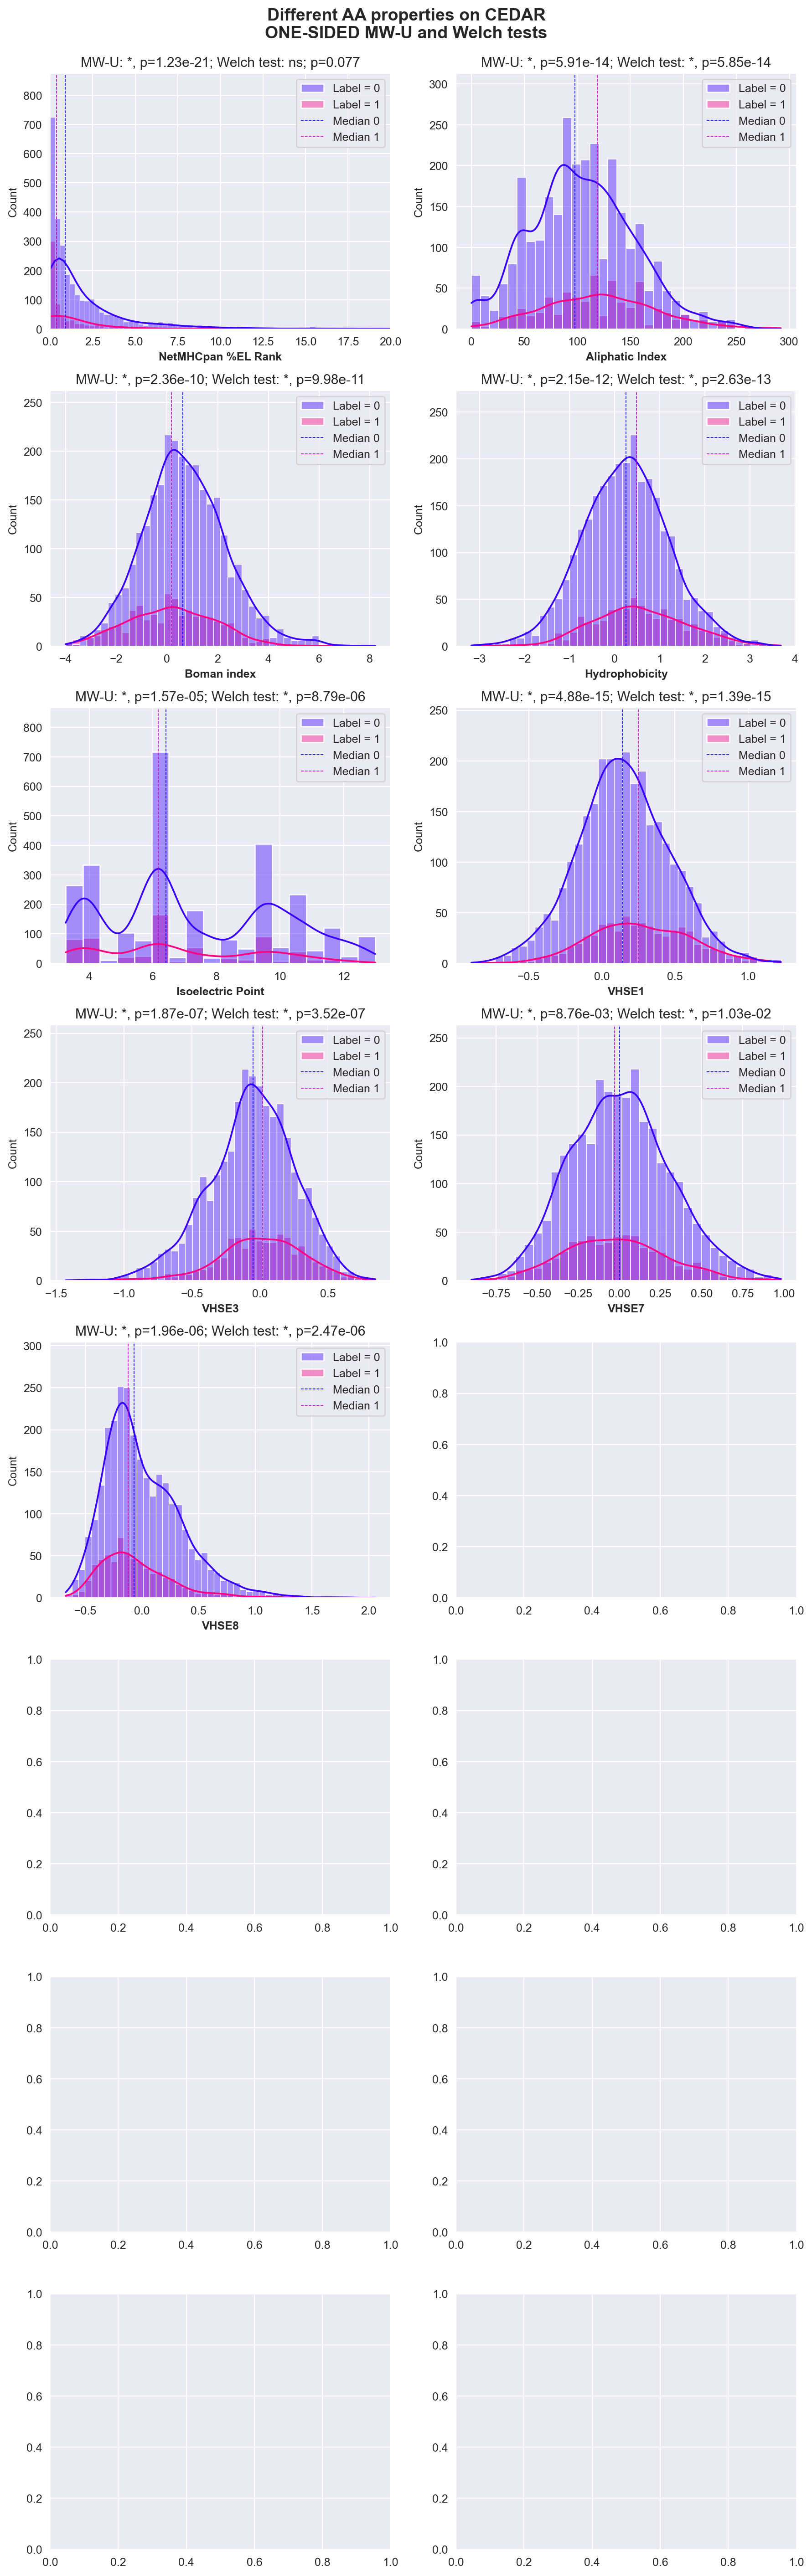

In [17]:
plot_aaprops(df, index)

Text(0.5, 1.0, 'Spearman correlation on CEDAR data')

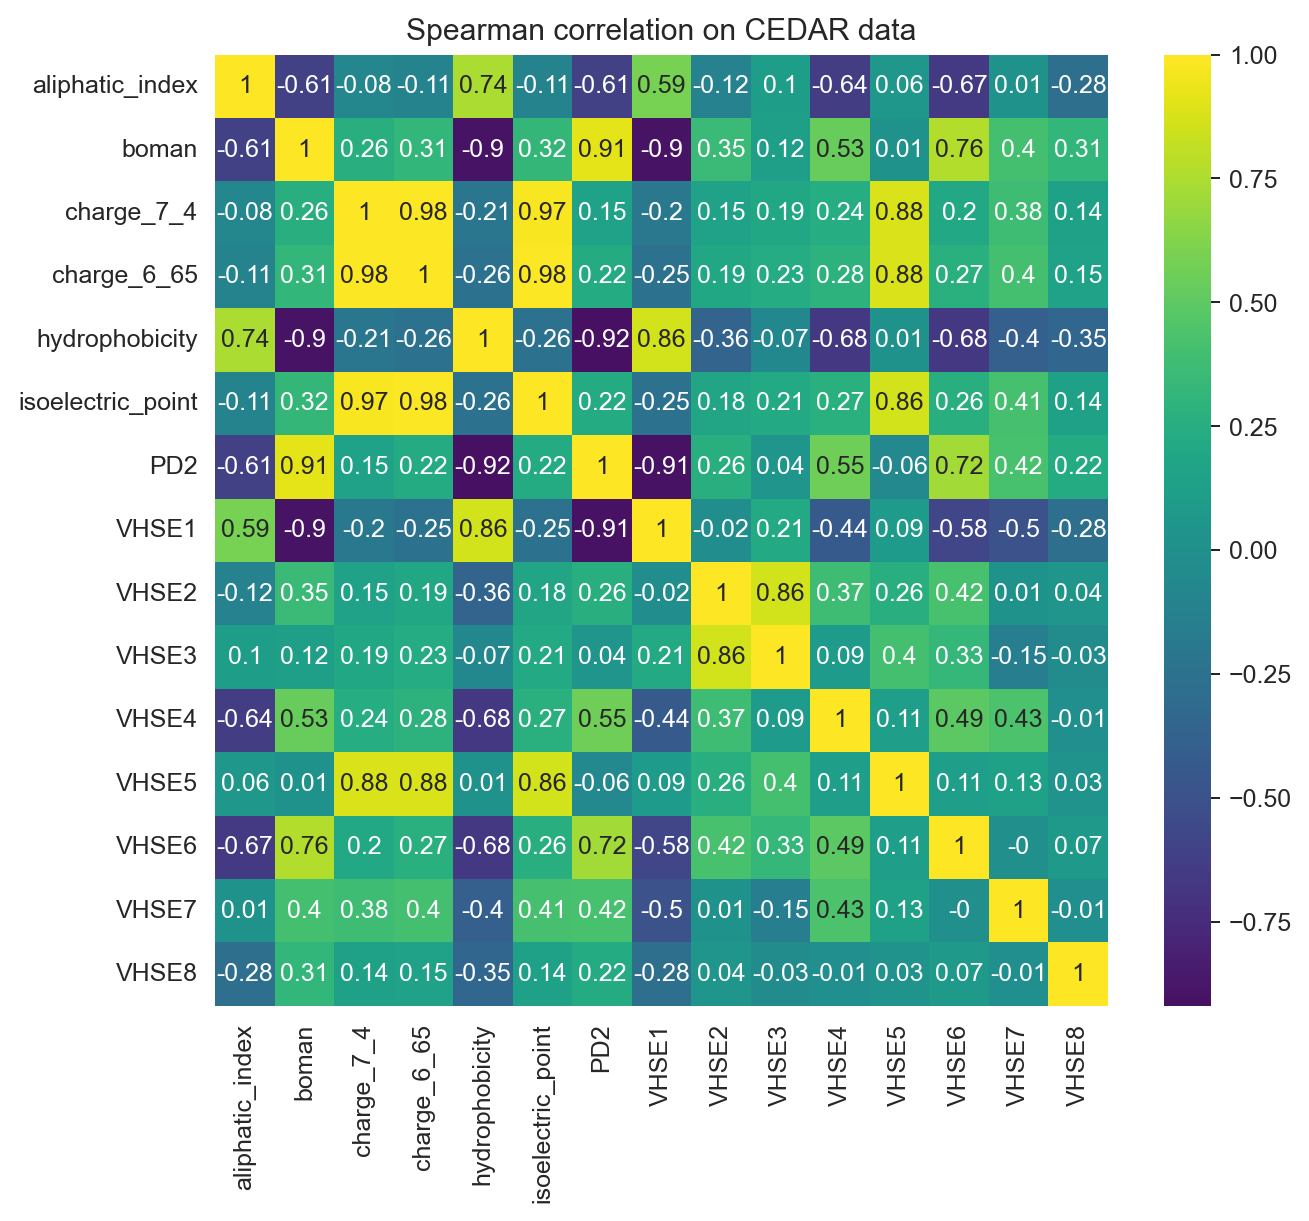

In [49]:
f,a = plt.subplots(1,1, figsize=(8,7))
sns.set_palette('viridis')
corr = df[index].corr('spearman')
sns.heatmap(corr.round(2), center=0, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap = 'viridis', vmax=1, annot = True)
a.set_title('Spearman correlation on CEDAR data')

Text(0.5, 1.0, 'Spearman correlation on PRIME data')

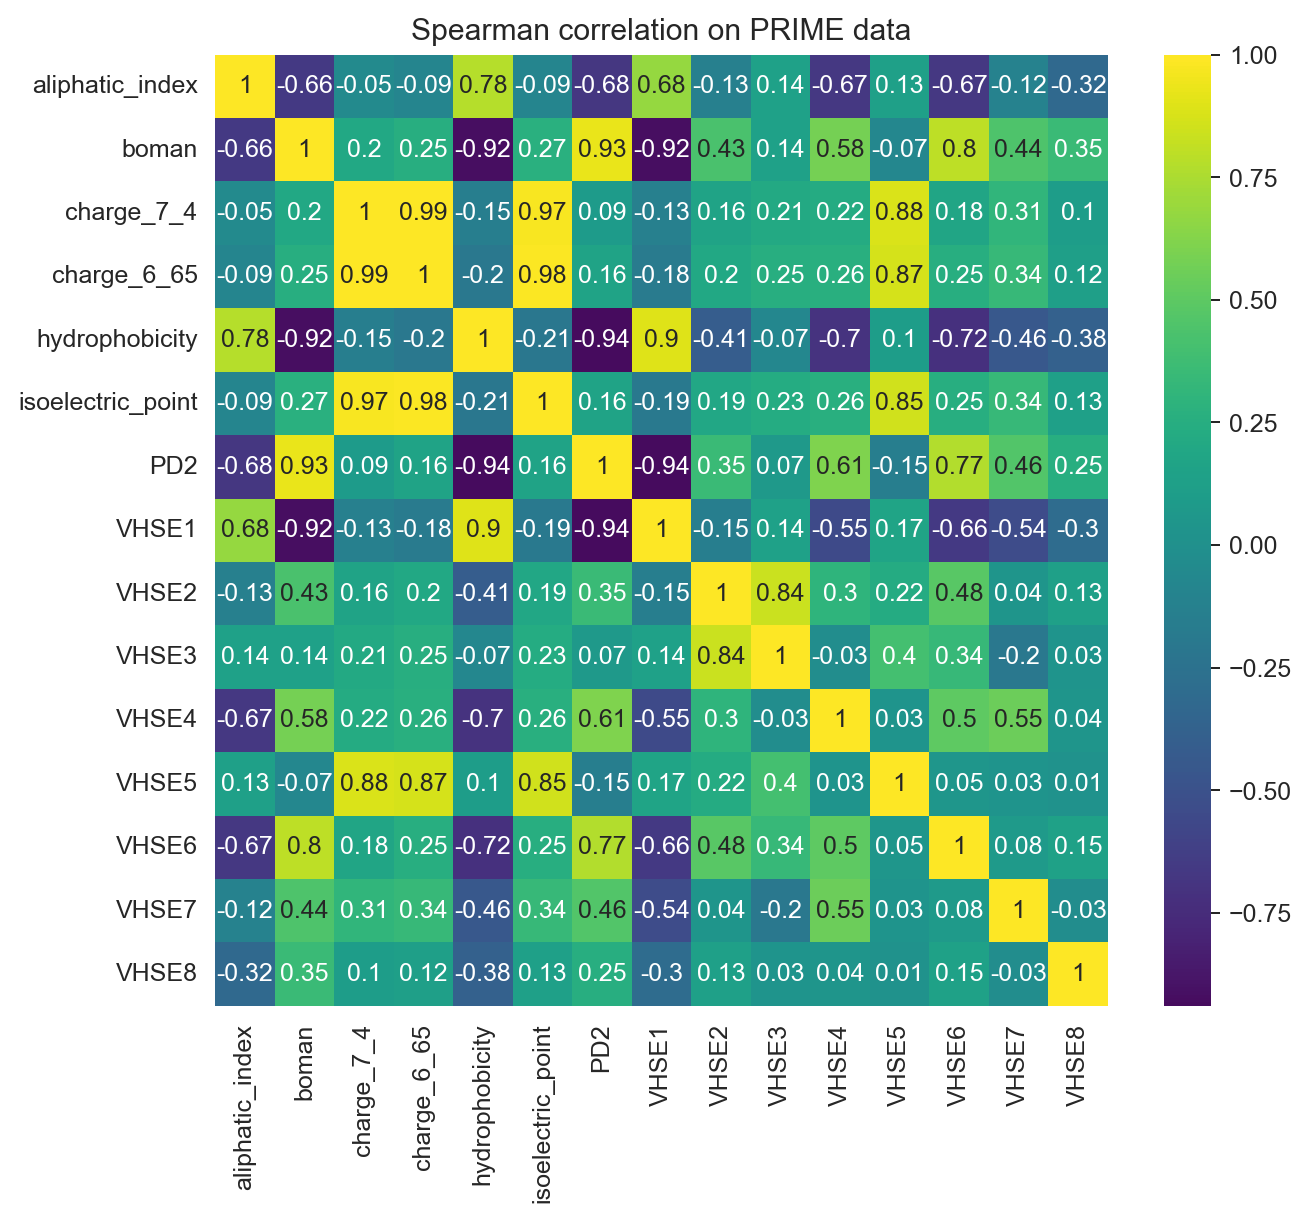

In [48]:
f,a = plt.subplots(1,1, figsize=(8,7))
sns.set_palette('viridis')
corr_p = df_p[index].corr('spearman')
sns.heatmap(corr_p.round(2), center=0, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap = 'viridis', vmax=1, annot = True)
a.set_title('Spearman correlation on PRIME data')

# Redo with new feats

In [5]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230308_nepdb_aligned_pepx.csv')

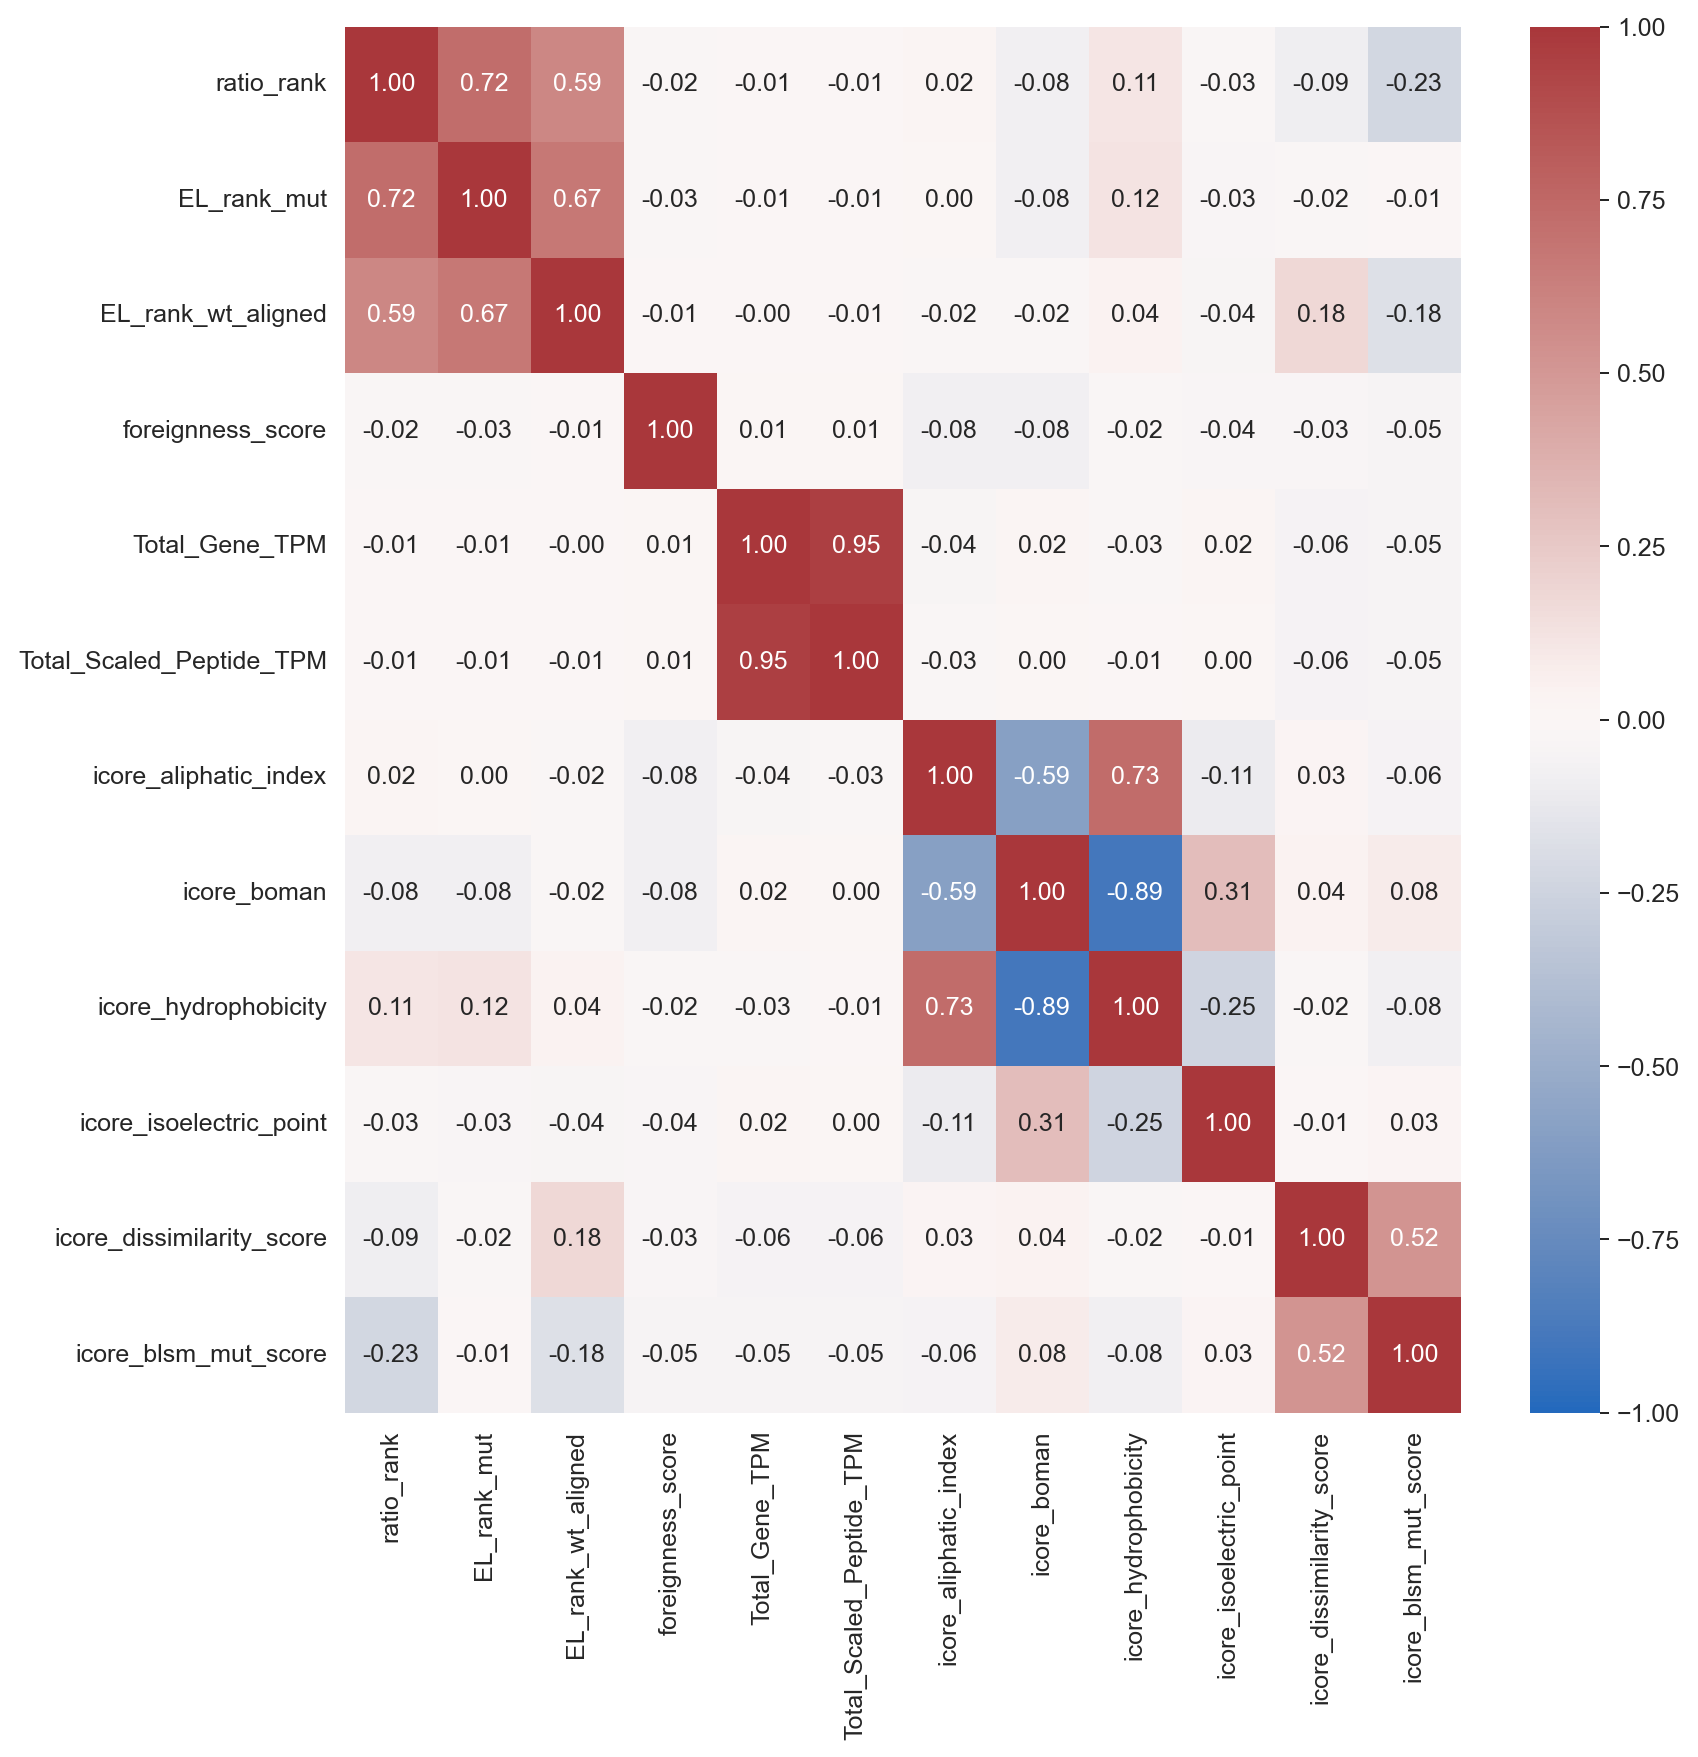

In [6]:
from scipy.stats import ttest_ind, mannwhitneyu
xd, _ = get_aa_properties(cedar_aligned_expr, 'icore_mut', False, 'icore_')
features=['ratio_rank', 'EL_rank_mut', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM', 'Total_Scaled_Peptide_TPM', 'icore_aliphatic_index', 'icore_boman', 'icore_hydrophobicity', 'icore_isoelectric_point', 'icore_dissimilarity_score', 'icore_blsm_mut_score']
corr= xd[features].corr(method='spearman')
f,a = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(corr, center=0, vmin=-1, vmax=1, cmap='vlag', annot=True, fmt='.2f', ax=a)
f.savefig('../../../writing/230131_cedar_paper_1/230414_feature_correlations.png', dpi=200, bbox_inches='tight')

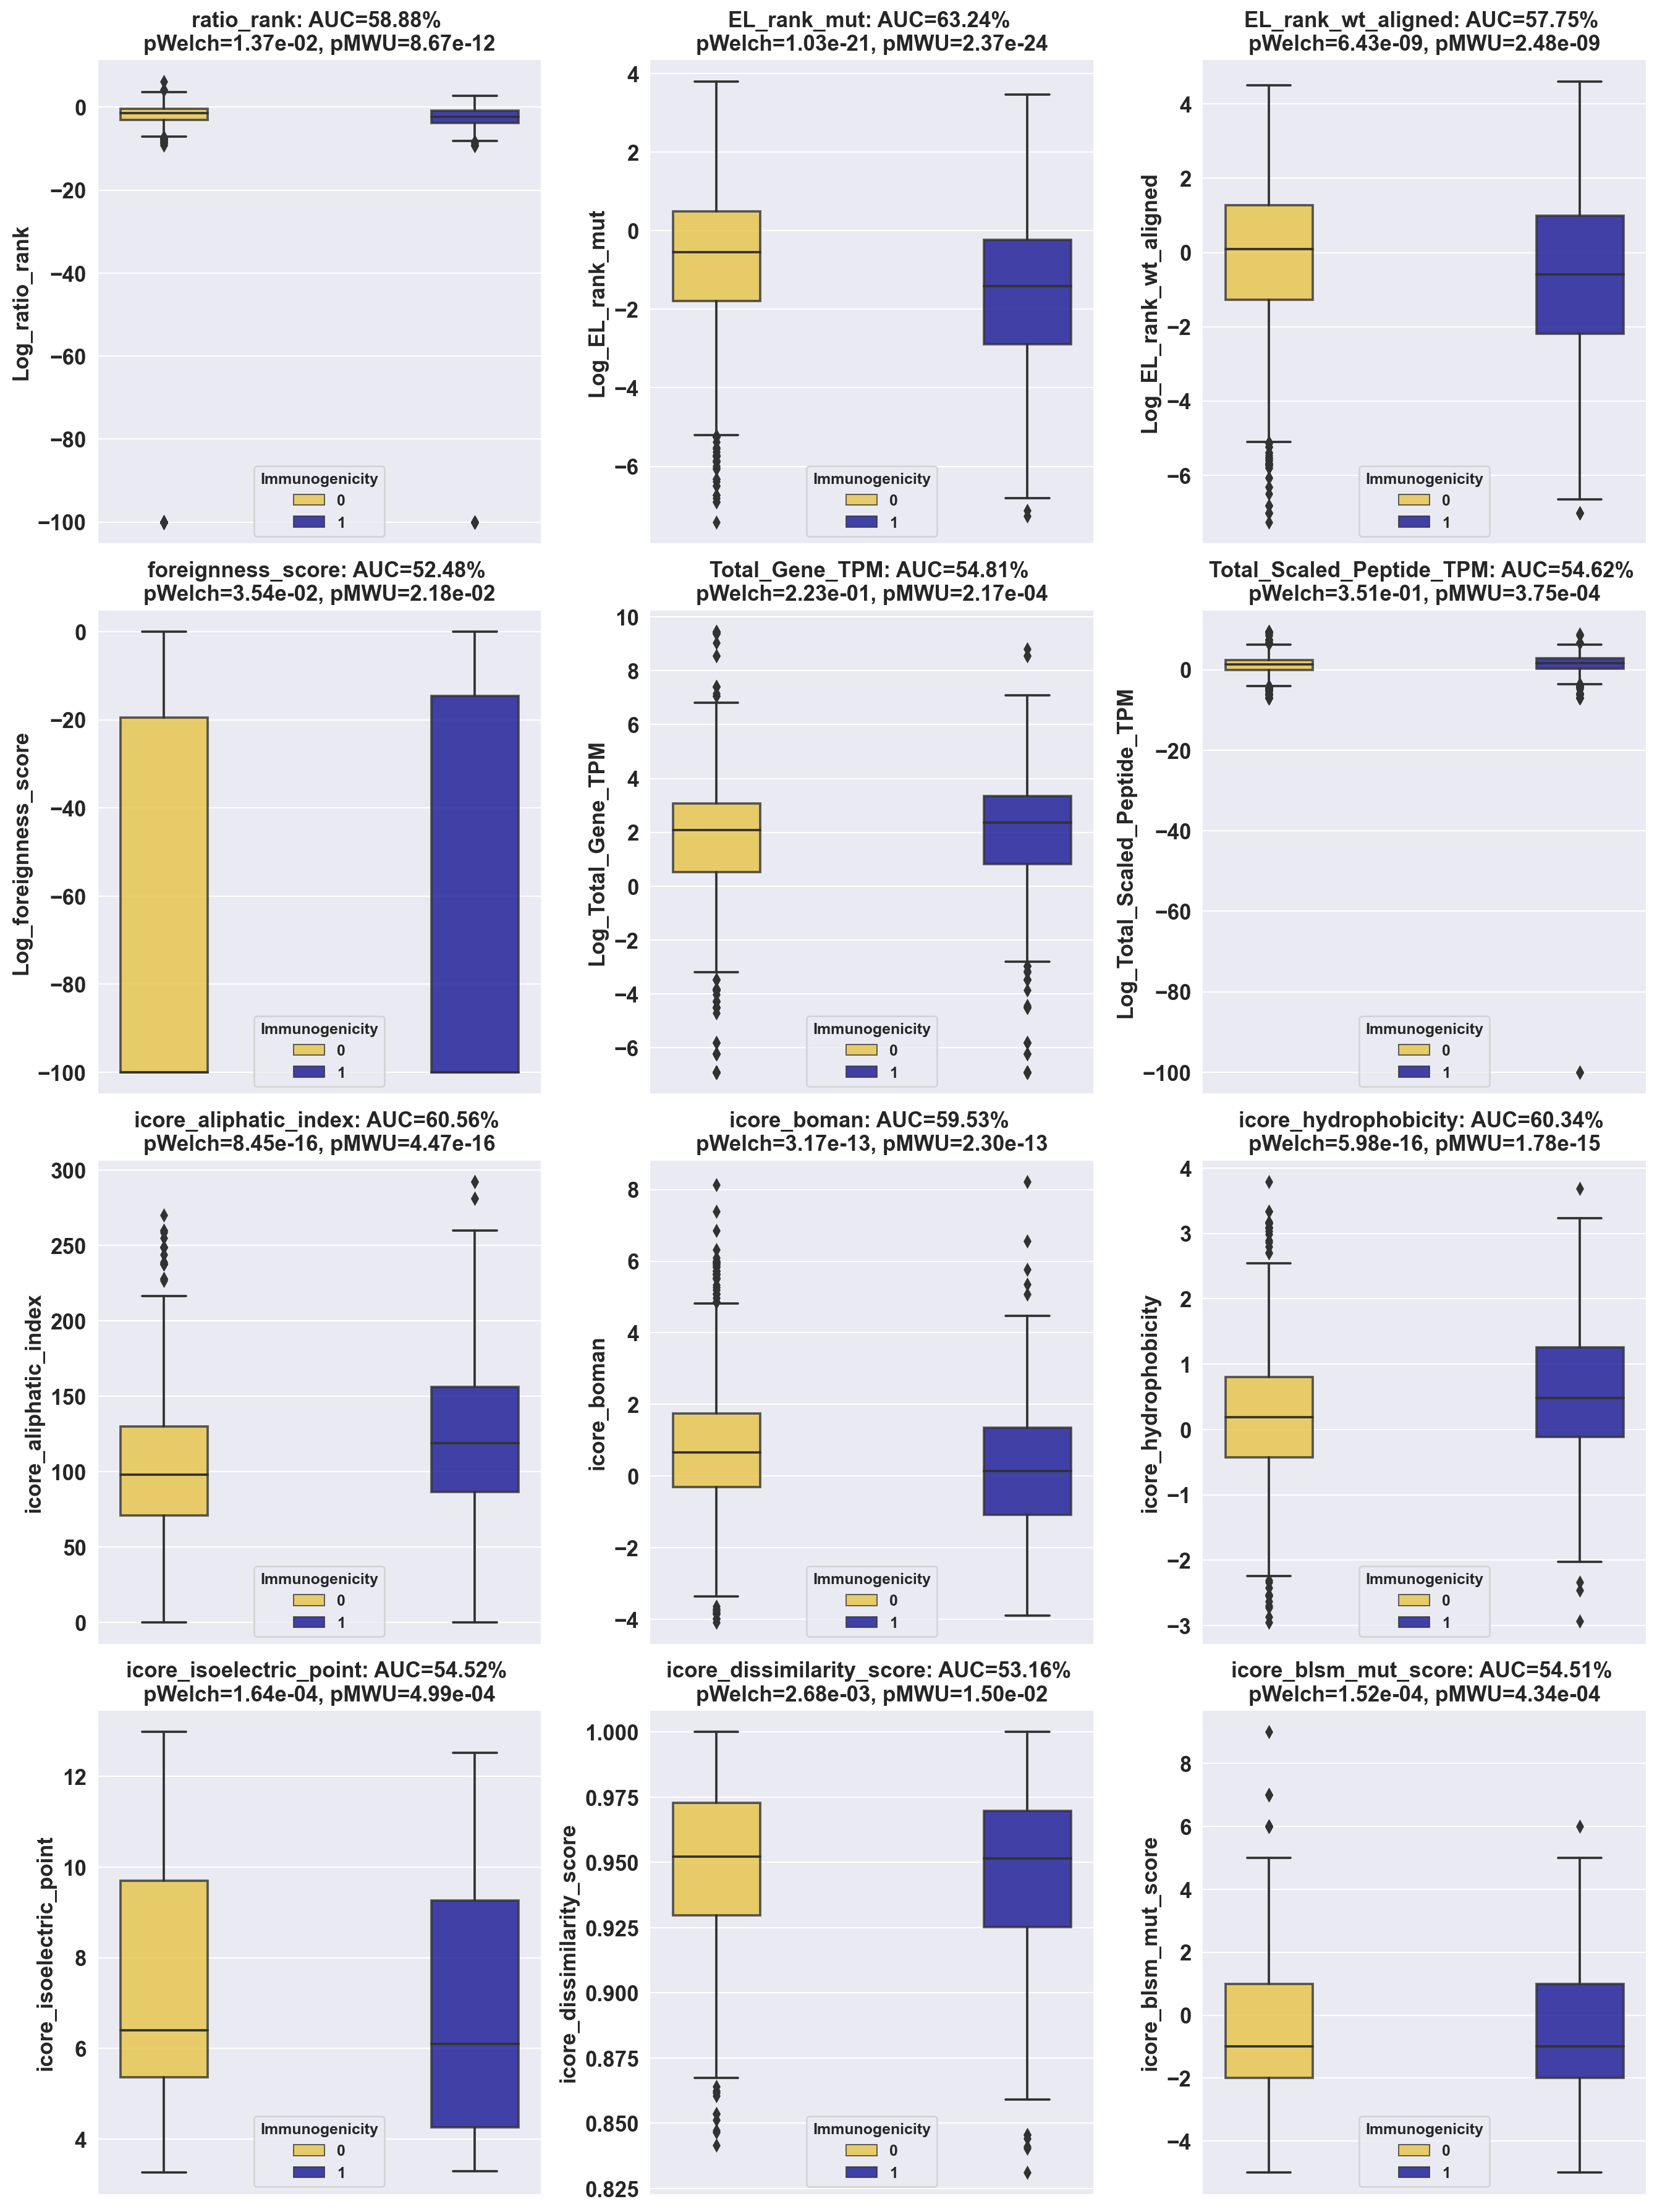

In [18]:
from sklearn.metrics import roc_auc_score
from src.utils import get_palette
f,a = plt.subplots(4,3, figsize=(15,20), sharex=True)
a = a.ravel()
sns.set_palette(get_palette('gnuplot2_r', 2))

xd['Immunogenicity'] = xd['agg_label']
for feat, ax in zip(features, a.ravel()):
    if 'icore' not in feat:
        xd[f'Log_{feat}'] = xd[feat].apply(np.log)
        xd[f'Log_{feat}'].replace(-np.inf, -100,inplace=True)
        sns.boxplot(data=xd, y=f'Log_{feat}', x='Immunogenicity', hue='Immunogenicity', ax=ax)
        plt.setp(ax.patches, alpha=0.8)
        # sns.swarmplot(data=xd, y=f'Log_{feat}', x='agg_label', hue='agg_label', ax=ax, size=3, edgecolor='k', dodge=True)
        ax.set_ylabel(f'Log_{feat}')
        a=xd.query('Immunogenicity==0')[f'Log_{feat}'].values
        b=xd.query('Immunogenicity==1')[f'Log_{feat}'].values
        if 'rank' in feat:
            auc = roc_auc_score(xd.agg_label.values, 1-xd[f'Log_{feat}'].values)
        else:
            auc = roc_auc_score(xd.agg_label.values, xd[f'Log_{feat}'].values)
    else:
        sns.boxplot(data=xd, y=feat, x='Immunogenicity', hue='Immunogenicity', ax=ax)
        plt.setp(ax.patches, alpha=0.8)
        # sns.swarmplot(data=xd, y=feat, x='agg_label', hue='agg_label', ax=ax,  size=3, edgecolor='k', dodge=True)
        a=xd.query('Immunogenicity==0')[feat].values
        b=xd.query('Immunogenicity==1')[feat].values
        if any([x in feat for x in ['boman', 'dissim', 'blsm', 'isoelectric']]):
            auc = roc_auc_score(xd.agg_label.values, 1-xd[feat].values)
        else:
            auc = roc_auc_score(xd.agg_label.values, xd[feat].values)
    ax.set_xlabel('')
    ax.set_xticklabels(['',''])
    ax.legend(title='Immunogenicity', loc='lower center',
              title_fontproperties={'weight':'semibold'},
              prop={'weight':'semibold'})
    pvalw = ttest_ind(a,b, equal_var=False)[1]
    pvalmwu = mannwhitneyu(a,b)[1]
    ax.set_ylabel(ax.get_ylabel(), fontweight='semibold', fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight='semibold', fontsize=14)
    ax.set_title(f'{feat}: AUC={auc:.2%} \npWelch={pvalw:.2e}, pMWU={pvalmwu:.2e}',fontsize=14,fontweight='semibold')
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/submission_nar/figures_redo/231120_FigS4_FeatDist.png', dpi=300, bbox_inches='tight')